<a id = 'returnToTop'></a>

# Table of contents
  * A. [What's so important about NN model parameters?](#introToModelParams)  
  * B. [Let's create our base model](#createOurModel)
  * C. [Layer Activation](#layerActivation)  
  * D. [Weight Initialization](#initializationFunctions)  
  * E. [Optimizers](#optimizers) 
  * F. [Normalization](#batchNormalization) 
  * G. [Bonus Section](#errorAnalysis)

<a id = 'introToModelParams'></a>
# A. What's so important about NN model parameters?

Having appropriate model features can mean the difference being a model being able to learn effectively or not.  In the early 2000's neural net models suffered from the vanishing / exploding gradient problem.  Incremental innovations led to discoveries to overcome that problem, some of which we'll introduce here.  Most of these are considered de regueur today but at the time they were each revolutionary.

In this lesson, we'll learn about some important model choices such as:
  * layer activation choice
  * initialization of weights
  * optimizers
  * normalization strategies


In [53]:
import tensorflow as tf
assert(tf.__version__.startswith("2."))
from importlib import reload

import pandas as pd
import numpy as np

import os

# Keras libraries
from tensorflow.keras import initializers
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import backend
assert(tf.__version__.startswith("2."))
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras import Model, layers

# Tensorboard
from tensorflow.python.keras.callbacks import TensorBoard
import datetime

from sklearn.model_selection import train_test_split

# For error analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Our model description

We will develop a model with a word input and predicting the part of speech.  Our dataset will be a modified version of mobypos.txt from the Gutenberg project: https://archive.org/details/mobypartofspeech03203gut

We've taken the original part of speech corpus (which had over 100 POS classes) and filtered it to only:  (1) 6 parts of speech  (2) words contained in the GloVe embeddings corpus.

Our goal is to see if a model leveraging GloVe can accurately predict the part of speech given in our training Moby corpus.

In [4]:
# Point to your existing GloVe download dataset from a3
# Note:  This assumes you've already run the glove commands to download glove for a3!
! if [[ ! -e data ]]; then ln -s ../../../assignment/a3/data .; fi

# Point to glove_helper utility in a3
! if [[ ! -e glove_helper.py ]]; then     ln -s ../../../assignment/a3/glove_helper.py .; fi

# Point to w266_common in a3
! if [[ ! -e w266_common ]]; then     ln -s ../../../assignment/a3/w266_common .; fi

import glove_helper; reload(glove_helper)
embedding_dim = 100  # 50, 100, 200, 300 dim are available

hands = glove_helper.Hands(ndim=embedding_dim)  


Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [5]:
# We can load a pre-trained embedding matrix into Keras as follows (using GloVe)
print('Our downloaded GloVe shape:  {}'.format(hands.W.shape))

# Create a model, pre-load GloVe model into keras Embedding layer:
num_tokens = hands.W.shape[0]
embedding_matrix = hands.W

# Load GloVe embedding matrix into Keras embedding layer
embedPretrain = Embedding(num_tokens,
                          embedding_dim,
                          embeddings_initializer=initializers.Constant(
                              embedding_matrix),
                          trainable=False)

# We will use this pre-trained embedding in our model

Our downloaded GloVe shape:  (400003, 100)


In [6]:
# Let's load our smaller Moby training dataset

# posdf = pd.read_csv("mobysmall.txt", sep=',', header = None, names = ['word', 'pos'])
posdf = pd.read_csv("normalization/mobypos_singlepos.txt", sep=',', header = None, names = ['word', 'pos'])

# Let's look at an example word
print(posdf.iloc[5])

# We'll add a column that is the GloVe 'id' for the word (or 2 for <unk>)
posdf['id'] = posdf.loc[:,'word'].apply(lambda x: hands.vocab.word_to_id.get(x, 2))

# Further eliminate all training words not already in GloVe
validdf = posdf.loc[posdf['id'] != 2, :]
validdf.reset_index(drop = True, inplace = True)

# Count how many word samples we're left with
print('\nThere are {} word/POS samples in our dataset.'.format(len(validdf)))

word    a bon march
pos               v
Name: 5, dtype: object

There are 56227 word/POS samples in our dataset.


In [7]:
# Look at part of speech (POS) labels

allpos = validdf['pos'].unique()
print('There are {} unique parts of speech labels:  {}'.format(len(allpos), allpos))

# Key to pos as encoded by  Moby Part-of-Speech II author, Grady Ward:
#     Noun                    N
#     Plural                  p
#     Noun Phrase             h
#     Verb (usu participle)   V
#     Verb (transitive)       t
#     Verb (intransitive)     i
#     Adjective               A
#     Adverb                  v
#     Conjunction             C
#     Preposition             P
#     Interjection            !
#     Pronoun                 r
#     Definite Article        D
#     Indefinite Article      I
#     Nominative              o

# Create a numeric class label for each output pos string label
pos2label = dict(zip(allpos, range(len(allpos))))
label2pos = dict(zip(range(len(allpos)), allpos))

# The first few rows of our dataframe
print(validdf.head())
print()

# Print number of samples in each class
for i in range(len(allpos)):
    pos = label2pos[i]
    print('POS {} has {} examples.'.format(pos, len(validdf.loc[validdf['pos'] == pos, :])))

There are 12 unique parts of speech labels:  ['N' 'v' 'A' 'V' 'p' 't' 'i' 'P' 'D' 'C' 'r' 'h']
       word pos      id
0  aardvark   N   89193
1  aardwolf   N  331196
2        aa   N   13479
3     abaca   N  166697
4     aback   v   31658

POS N has 29759 examples.
POS v has 2631 examples.
POS A has 12069 examples.
POS V has 5370 examples.
POS p has 2426 examples.
POS t has 3028 examples.
POS i has 677 examples.
POS P has 84 examples.
POS D has 58 examples.
POS C has 40 examples.
POS r has 65 examples.
POS h has 20 examples.


In [22]:
# Our dataset is not very balanced as there are many more nouns (N) and Adjectives (A) than other POS.
# ...Nonetheless we can still guage accuracy fairly well given that no single class has more than
# ...56% so even clinging to simple baseline of the dominant (N) class would give only slightly better
# ...than a random guess.

# Our model input be fed with a single word:
n_words = 1
x_ids = validdf['id'].to_numpy()
# Encode each pos as a number
y_ids = np.array([pos2label[pos] for pos in validdf['pos']])

# We need to create one-hot categorical variables for labels
x_ids = x_ids.reshape(-1,1)
y_ids = y_ids.reshape(-1,1)
# y_ids = tf.keras.utils.to_categorical(y_ids, num_classes = len(allpos))

# Expand dims to insert dim = 1 y-class label at position 1
# y_ids = np.expand_dims(y_ids, axis = 1)

# Create training, test sets
X_train, X_test, y_train, y_test = train_test_split(x_ids, y_ids, test_size=0.33, 
                                                    random_state=42, shuffle = True)

batch_size = 100

# Print out the first few examples:
for i in range(5):
    # print('  word: {},  pos label: {}'.format(hands.vocab.id_to_word[X_train[i][0]], label2pos[np.where(y_train[i][0]==1)[0][0]]))
    print('  word: {},  pos label: {}'.format(hands.vocab.id_to_word[X_train[i][0]], label2pos[y_train[i][0]]))

  word: unviable,  pos label: A
  word: sawdust,  pos label: N
  word: exclusivity,  pos label: N
  word: double-hung,  pos label: A
  word: coruscant,  pos label: A


<a id = 'createOurModel'></a>
# B. Let's create our base NN Model

We've created a function which returns a model given a dict of input model params.  This will make it easier to try various modifications to the model later.

In [23]:
# Build a simple keras model to predict POS
# Model parameters
modelParams = dict(
    batch_size = batch_size, 
    learning_rate = 0.01,
    n_words = 1,
    num_layers = 10,
    H = 40,
    hidden_initializer = 'random_uniform',
    hidden_activation = 'sigmoid',
    batchnorm = False,
    output_classes = len(allpos),
    output_initializer = 'random_uniform',
    output_activation = 'softmax',
    output_loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

# Define a function to create our LSTM model
def create_pos_classifier(**kwargs):
    
    # Read input keyword args
    batch_size = kwargs.get('batch_size', 100) 
    learning_rate = kwargs.get('learning_rate', 0.01)
    n_words = kwargs.get('n_words', 1)
    num_layers = kwargs.get('num_layers', 1)
    H = kwargs.get('H', 10)
    hidden_initializer = kwargs.get('hidden_initializer', 'random_uniform')
    hidden_activation = kwargs.get('hidden_activation', 'relu')
    batchnorm = kwargs.get('batchnorm', False)
    output_classes = kwargs.get('output_classes', 6)
    output_initializer = kwargs.get('output_initializer', tf.keras.initializers.RandomUniform(minval=-1.0, maxval=1.0))
    output_activation = kwargs.get('output_activation', 'softmax')
    output_loss = kwargs.get('output_loss', tf.keras.losses.CategoricalCrossentropy())
    metrics = kwargs.get('metrics', ['accuracy'])
    
    # Create an input layer for our model
    input_ = Input(shape = (n_words,), name="x")
    
    # Use GloVe pre-trained embeddings
    embedPretrain = Embedding(num_tokens, embedding_dim, 
                              embeddings_initializer=initializers.Constant(embedding_matrix),
                              trainable=False)
    x = embedPretrain(input_)
    
    # Create hidden layers
    for i in range(num_layers):
        x = Dense(units = H, activation = None, kernel_initializer = hidden_initializer)(x)
        if (batchnorm):
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(hidden_activation)(x)
    
    # Create an output layer with softmax output type
    outlayer = Dense(units = output_classes, activation = output_activation,
                     kernel_initializer = output_initializer)
    yhat = outlayer(x)
    
    # Use Adam optimizer with our programmed learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, name='Adam')
    
    # Build / compile the model
    model = Model(inputs=input_, outputs=yhat, name="rnn_prediction_model")
    model.compile(loss = output_loss, optimizer = optimizer, metrics = metrics)
    return model


In [24]:
# Build model using our previous model parameter settings, show a summary and fit the model
modelSimple = create_pos_classifier(**modelParams)
modelSimple.summary()
# Run a training session
modelSimple.fit(X_train, y_train, batch_size = 100, validation_data = (X_test, y_test), epochs = 30)

Model: "rnn_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 1)]               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1, 100)            40000300  
_________________________________________________________________
dense_22 (Dense)             (None, 1, 40)             4040      
_________________________________________________________________
activation_20 (Activation)   (None, 1, 40)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 1, 40)             1640      
_________________________________________________________________
activation_21 (Activation)   (None, 1, 40)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 1, 40)    

In [11]:
# We can check out our model results and see how it compares with our labels.
# You can also directly calculate CE loss for y_hat against y.
for xin, ytrue in list(zip(X_train[:4], y_train[:4])):
    # xin, ytrue = batch[0].numpy(), batch[1].numpy()
    y_hat = modelSimple.predict([xin]).reshape([1,-1])
    print('xid: {}\ny_hat: {}\nytrue: {}'.format(xin, y_hat, ytrue))
    cce = tf.keras.losses.CategoricalCrossentropy()
    print('Categorical cross-entropy loss: {}\n\n'.format(cce(ytrue, y_hat).numpy()))

# We could also do an error analysis to compare what words it still gets wrong.
# Try this as an exercise to see where the model is weakest!

xid: [100000]
y_hat: [[5.4471207e-01 4.3865800e-02 2.1851785e-01 8.4867366e-02 3.9082769e-02
  5.3260811e-02 1.1232356e-02 1.1380898e-03 1.1680303e-03 5.5763137e-04
  1.3003853e-03 2.9683128e-04]]
ytrue: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Categorical cross-entropy loss: 1.5208874940872192


xid: [50133]
y_hat: [[5.4471207e-01 4.3865800e-02 2.1851785e-01 8.4867366e-02 3.9082769e-02
  5.3260811e-02 1.1232356e-02 1.1380898e-03 1.1680298e-03 5.5763137e-04
  1.3003853e-03 2.9683128e-04]]
ytrue: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Categorical cross-entropy loss: 0.6074979305267334


xid: [36284]
y_hat: [[5.4471207e-01 4.3865800e-02 2.1851785e-01 8.4867366e-02 3.9082769e-02
  5.3260811e-02 1.1232356e-02 1.1380898e-03 1.1680303e-03 5.5763137e-04
  1.3003853e-03 2.9683128e-04]]
ytrue: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Categorical cross-entropy loss: 0.6074979305267334


xid: [165577]
y_hat: [[5.4471207e-01 4.3865800e-02 2.1851785e-01 8.4867366e-02 3.9082769e-02
  5.3260811e-02 1.

[Return to Top](#returnToTop) 
<a id = 'layerActivation'></a>
# C. Layer Activations

As you've learned in class, 'softmax' is used when you want to predict probabilites.  This is exactly the situation for our current example, where we are output probability for each of our 6 pos classes.  In fact, if you opted to output 'sigmoid' instead, your model would 'learn' that it can output near-0 loss by simply setting each output class to '1', thereby always hitting the correct class.  Of course it wouldn't actually be learning anything.

The activation 'tanh' has an advantage over 'sigmoid' for being 0-valued at x = 0.  'relu' is also 0-valued at x = 0 and has the additional advantage of not saturating for x > 0 for helping maintain a non-zero differentiable loss function during backward propagation; you can try other choices for activation in your model.

In [18]:
modelParams['hidden_activation'] = 'relu'  # You could also try 'tanh' or 'selu' 
# ...for Scaled Exponential Linear Unit
modelHiddenAct = create_pos_classifier(**modelParams)
modelHiddenAct.fit(X_train, y_train, batch_size = 100, validation_data = (X_test, y_test), epochs = 30)

# If you want to see how 'sigmoid' for the output layer won't work, uncomment and try the below code:
# modelParams['hidden_activation'] = 'relu' # reset hidden activation
# modelParams['output_activation'] = 'sigmoid'  # This will produce bad results...  (why?)
# modelOutputSigmoid = create_pos_classifier(**modelParams)
# modelOutputSigmoid.fit(trainds, validation_data = testds, epochs = 3)

Epoch 1/30
377/377 [==============================] - 2s 2ms/step - loss: 1.3663 - accuracy: 0.5633 - val_loss: 0.9292 - val_accuracy: 0.6968
Epoch 2/30
377/377 [==============================] - 1s 2ms/step - loss: 0.9316 - accuracy: 0.6962 - val_loss: 0.9005 - val_accuracy: 0.7100
Epoch 3/30
377/377 [==============================] - 1s 2ms/step - loss: 0.8978 - accuracy: 0.7133 - val_loss: 0.8732 - val_accuracy: 0.7228
Epoch 4/30
377/377 [==============================] - 1s 2ms/step - loss: 0.8752 - accuracy: 0.7141 - val_loss: 0.8578 - val_accuracy: 0.7174
Epoch 5/30
377/377 [==============================] - 1s 2ms/step - loss: 0.8341 - accuracy: 0.7226 - val_loss: 0.8398 - val_accuracy: 0.7200
Epoch 6/30
377/377 [==============================] - 1s 2ms/step - loss: 0.8231 - accuracy: 0.7343 - val_loss: 0.8154 - val_accuracy: 0.7470
Epoch 7/30
377/377 [==============================] - 1s 2ms/step - loss: 0.7906 - accuracy: 0.7573 - val_loss: 0.7953 - val_accuracy: 0.7516
Epoch 

[Return to Top](#returnToTop) 
<a id = 'initializationFunctions'></a>
# D. Weight Initialization

Weight initialization is another important tool for avoiding exploding, vanishing gradients problem.
In the deep neural net early days, random uniform initialization of weights was common.  There appeared to be two problems:  (1) gradients could end up vanishing (or exploding) as they were calculated in moving from layer output to input and (2) signals could end up vanishing (or exploding) as they propagated from input to output in a forward direction through the layer.  

A ground-breaking paper presented by Glorot and Bengio in 2010  (http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) described a way to initialize weights so as to avoid vanishing or exploding signals during inference and likewise to minimize vanishing/exploding gradients during backward propagation.  The goal is to keep input and output variance equal as well as output and input gradient variance.  Out of the paper was born 'Xavier' initialization (also known as 'Glorot uniform'.)

Soon afterwards, the 'relu' activation function was seen to be an effective way to avoid moving the signal mean away from 0, as well as mitigating signal saturation.  At the same time, [the 'He' initialization introduced in this 2015 paper by He et al](https://arxiv.org/pdf/1502.01852v1.pdf) was presented as an improvement over 'Xavier' when using 'relu' activation.



In [19]:
modelParams['hidden_activation'] = 'relu'  
modelParams['hidden_initializer'] = 'he_uniform' # He uniform initialization works better for relu
modelParams['output_initializer'] = 'he_uniform'
modelHeInit = create_pos_classifier(**modelParams)
modelHeInit.fit(X_train, y_train, batch_size = 100, validation_data = (X_test, y_test), epochs = 30)

# You can also use LeCun initialization when using the SELU activation
# modelParams['hidden_activation'] = 'selu'  
# modelParams['output_initializer'] = 'lecun_normal' # LeCun initialization works better for selu
# modelLeCunInit = create_pos_classifier(**modelParams)
# modelLeCunInit.fit(trainds, validation_data = testds, epochs = 3)

Epoch 1/30
377/377 [==============================] - 2s 2ms/step - loss: 1.0606 - accuracy: 0.6615 - val_loss: 0.6943 - val_accuracy: 0.7826
Epoch 2/30
377/377 [==============================] - 1s 2ms/step - loss: 0.6987 - accuracy: 0.7853 - val_loss: 0.6643 - val_accuracy: 0.7915
Epoch 3/30
377/377 [==============================] - 1s 2ms/step - loss: 0.6600 - accuracy: 0.7988 - val_loss: 0.6894 - val_accuracy: 0.7961
Epoch 4/30
377/377 [==============================] - 1s 2ms/step - loss: 0.6399 - accuracy: 0.8095 - val_loss: 0.6773 - val_accuracy: 0.7991
Epoch 5/30
377/377 [==============================] - 1s 2ms/step - loss: 0.6277 - accuracy: 0.8082 - val_loss: 0.6645 - val_accuracy: 0.7968
Epoch 6/30
377/377 [==============================] - 1s 2ms/step - loss: 0.6226 - accuracy: 0.8098 - val_loss: 0.6418 - val_accuracy: 0.8004
Epoch 7/30
377/377 [==============================] - 1s 2ms/step - loss: 0.5927 - accuracy: 0.8188 - val_loss: 0.6423 - val_accuracy: 0.8010
Epoch 

[Return to Top](#returnToTop)  
<a id = 'optimizers'></a>
## E. Optimizers

For training steps, you can use any optimizer, but we recommend `tf.train.AdamOptimizer` with gradient clipping (`tf.clip_by_global_norm`).  Adam adjusts the learning rate on a per-variable basis, and also adds a "momentum" term that improves the speed of convergence. See [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/) for more.

For training with AdamOptimizer, a good value is `learning_rate = 0.01` as defined under "Training Parameters" (next to batch size, num epochs, etc.). If you use `learning_rate = 0.1` with Adam, the model will likely overfit or training may be unstable. (However, 0.1 works well with Adagrad and vanilla SGD.)


[Return to top](#top)
<a id = 'batchNormalization'></a>
# F. Batch Normalization

Whereas having good initialization of weights helps avoid gradient exploding / vanishing at the beginning of training, a technique called *batch normalization* helps maintain zero-mean / unity-variance of layer inputs during training.  

The technique involves computing a mean and standard deviation (averaged over the batch) for each input feature and using the mean and standard deviation vectors to normalize each feature.  Two additional learned parameters (beta and gamma) are used to further scale and shift the inputs to help maintain zero-offset.  

![Batch Normalization equations](./normalization/batch_normalization_equations.png)

The technique was presented in a 2015 paper by Ioffe and Szegedy (http://proceedings.mlr.press/v37/ioffe15.pdf).  

Keras provides a Batch Normalization layer which can be placed after hidden layers (or even after the Input() layer) to take care of this scaling / shifting.

Batch normalization tends to lengthen per-batch training computation time due to the requirement of computing batch means and batch variances.  The trade-off is that the quality of each training cycle tends to be better (by keeping layer inputs well-conditioned via scaling / shifting) which tends to have a net effect of improving the rate of accuracy improvement.

In [25]:
# Modify model to enable Batch Normalization layer
modelParams['batchnorm'] = True
modelSimple = create_pos_classifier(**modelParams)
modelSimple.summary()  # To see that batch normalization has been added
# Run a training session
modelSimple.fit(X_train, y_train, batch_size = 100, validation_data = (X_test, y_test), epochs = 30)

Model: "rnn_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 1)]               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1, 100)            40000300  
_________________________________________________________________
dense_33 (Dense)             (None, 1, 40)             4040      
_________________________________________________________________
batch_normalization_10 (Batc (None, 1, 40)             160       
_________________________________________________________________
activation_30 (Activation)   (None, 1, 40)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 1, 40)             1640      
_________________________________________________________________
batch_normalization_11 (Batc (None, 1, 40)    

[Return to top](#top)
<a id = 'errorAnalysis'></a>
# G. Bonus section:  Error Analysis

It is insightful to look at classification models to determine if systematic problems are happening that might cause a certain class to be under-predicted.  This might help find problems in the model, or suggest feature modifications for instance.



(37672,)
(37672,)


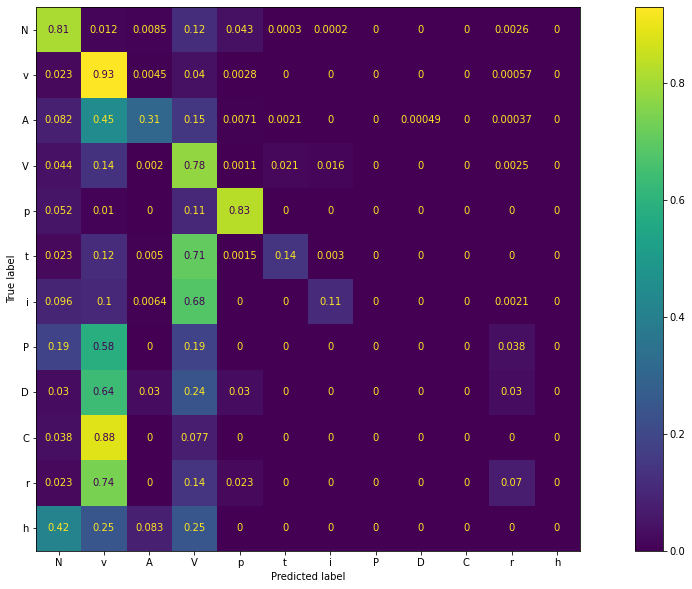

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
y_true = y_train.squeeze()
y_pred = modelSimple(X_train).numpy().argmax(axis=-1).squeeze()
# print(y_pred.argmax(axis=-1))
print(y_true.shape)
print(y_pred.shape)
cm = confusion_matrix(y_true, y_pred, normalize = 'true')
fig, ax = plt.subplots(figsize=(20, 10))
cm_display = ConfusionMatrixDisplay(cm, display_labels=[label2pos[i] for i in range(12)]).plot(ax = ax)

In [61]:
# What are the classes?
for i in range(12):
    print('{} class is {}'.format(i, label2pos[i]))

0 class is N
1 class is v
2 class is A
3 class is V
4 class is p
5 class is t
6 class is i
7 class is P
8 class is D
9 class is C
10 class is r
11 class is h
